# 04 - Supervised Learning (Classification)

This notebook includes:
- Target variable definition pass/fail
- Feature engineering and encoding
- Multiple classification algorithms
- Hyperparameter tuning
- Cross-validation
- Model interpretation

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

try:
    from xgboost import XGBClassifier

    print("XGBoost successfully imported!")
except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")
    XGBClassifier = None
import warnings

warnings.filterwarnings("ignore")

XGBoost successfully imported!


In [16]:
df = pd.read_pickle(r"../data/processed/cleaned_dataset.pkl")
df.drop(columns=["grade_average"], inplace=True)

In [17]:
# Handle different data types properly after preprocessing

# Apply encoding
df_encoded = df.copy()

# 1. ORDINAL VARIABLES - Convert ordered categoricals to numeric (preserve order)
ordinal_vars = [
    "Medu",
    "Fedu",
    "traveltime",
    "studytime",
    "famrel",
    "freetime",
    "goout",
    "Dalc",
    "Walc",
    "health",
]
for var in ordinal_vars:
    if var in df_encoded.columns:
        df_encoded[var] = df_encoded[
            var
        ].cat.codes  # Converts to 0,1,2,3,4 maintaining order
        print(f"Ordinal encoded {var}")

# 2. BINARY VARIABLES - Convert booleans to 0/1
binary_vars = [
    "schoolsup",
    "famsup",
    "paid",
    "activities",
    "nursery",
    "higher",
    "internet",
    "romantic",
]
for var in binary_vars:
    if var in df_encoded.columns:
        df_encoded[var] = df_encoded[var].astype(int)  # True->1, False->0
        print(f"Boolean to binary: {var}")

# 3. NOMINAL CATEGORICALS - Binary mapping for 2-level, one-hot for multi-level
# Binary mappings for 2-level categoricals
binary_mappings = {
    "school": {"GP": 1, "MS": 0},
    "sex": {"F": 1, "M": 0},
    "address": {"U": 1, "R": 0},
    "famsize": {"GT3": 1, "LE3": 0},
    "Pstatus": {"T": 1, "A": 0},
}

# Apply binary encoding
for col, mapping in binary_mappings.items():
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].map(mapping)
        print(f"Binary encoded {col}")

# Multi-level categorical columns for one-hot encoding
categorical_cols = ["Mjob", "Fjob", "reason", "guardian"]

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)
print(f"One-hot encoded: {categorical_cols}")
print(f"New shape after encoding: {df_encoded.shape}")

# 4. NUMERIC VARIABLES already handled (age, failures, absences, G1, G2, G3)

# Remove target leakage
features_to_drop = ["G3"]
X = df_encoded.drop(columns=features_to_drop + ["pass_fail"])
y = df_encoded["pass_fail"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Results
print(f"\nFinal results:")
print(f"Training shape: {X_train_scaled.shape}")
print(f"Test shape: {X_test_scaled.shape}")
print(f"Pass rate - Train: {y_train.mean():.1%}, Test: {y_test.mean():.1%}")
print(f"All features are now numeric and scaled.")

Ordinal encoded Medu
Ordinal encoded Fedu
Ordinal encoded traveltime
Ordinal encoded studytime
Ordinal encoded famrel
Ordinal encoded freetime
Ordinal encoded goout
Ordinal encoded Dalc
Ordinal encoded Walc
Ordinal encoded health
Boolean to binary: schoolsup
Boolean to binary: famsup
Boolean to binary: paid
Boolean to binary: activities
Boolean to binary: nursery
Boolean to binary: higher
Boolean to binary: internet
Boolean to binary: romantic
Binary encoded school
Binary encoded sex
Binary encoded address
Binary encoded famsize
Binary encoded Pstatus
One-hot encoded: ['Mjob', 'Fjob', 'reason', 'guardian']
New shape after encoding: (649, 44)

Final results:
Training shape: (519, 42)
Test shape: (130, 42)
Pass rate - Train: 84.6%, Test: 84.6%
All features are now numeric and scaled.


In [18]:
# Create two feature sets from the scaled data
print("Available features:", X.columns.tolist())

# Set 1: Keep all current features (includes G1, G2)
X_with_grades = X.copy()
X_train_with_grades = X_train_scaled.copy()
X_test_with_grades = X_test_scaled.copy()

# Set 2: Remove G1 and G2 from the scaled data
grade_columns = ["G1", "G2"]
grade_indices = [X.columns.get_loc(col) for col in grade_columns if col in X.columns]

X_without_grades = X.drop(columns=grade_columns)
X_train_without_grades = np.delete(X_train_scaled, grade_indices, axis=1)
X_test_without_grades = np.delete(X_test_scaled, grade_indices, axis=1)

# Results
print(f"\nFeature sets created:")
print(
    f"WITH G1, G2 - Train: {X_train_with_grades.shape}, Test: {X_test_with_grades.shape}"
)
print(
    f"WITHOUT G1, G2 - Train: {X_train_without_grades.shape}, Test: {X_test_without_grades.shape}"
)
print(f"Features removed: {grade_columns}")

Available features: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'attendance_proxy', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother', 'guardian_other']

Feature sets created:
WITH G1, G2 - Train: (519, 42), Test: (130, 42)
WITHOUT G1, G2 - Train: (519, 40), Test: (130, 40)
Features removed: ['G1', 'G2']


# Function-Based Model Implementation

## Logistic Regression

In [19]:
def logistic_regression_base(X_train, X_test, title):
    """Base Logistic Regression Model"""
    print(f"LOGISTIC REGRESSION MODEL {title.upper()}")

    # Initialize and train the model
    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train, y_train)

    # Make predictions on TEST data
    y_pred_lr = log_reg.predict(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_lr))

    # Logistic Regression metrics
    lr_accuracy = accuracy_score(y_test, y_pred_lr)
    lr_precision = precision_score(y_test, y_pred_lr)
    lr_recall = recall_score(y_test, y_pred_lr)
    lr_f1 = f1_score(y_test, y_pred_lr)

    # Confusion Matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_lr)
    plt.figure(figsize=(8, 6))
    lr_color = "#0d47a1"
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(lr_color, as_cmap=True),
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Logistic Regression - {title}")
    plt.show()

    return lr_accuracy, lr_precision, lr_recall, lr_f1


def logistic_regression_tuned(X_train, X_test, title):
    """Hyperparameter Tuned Logistic Regression Model"""
    print(f"HYPERPARAMETER TUNED LOGISTIC REGRESSION MODEL {title.upper()}")

    # Define the parameter grid
    param_grid = {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"],
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        LogisticRegression(random_state=42, max_iter=1000),
        param_grid,
        cv=5,
        scoring="f1",
        n_jobs=-1,
    )

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_log_reg = grid_search.best_estimator_

    # Print the best parameters
    print("Best Hyperparameters for Logistic Regression:")
    print(grid_search.best_params_)

    # Make predictions with the improved model
    y_pred_lr = best_log_reg.predict(X_test)

    # Evaluate the improved model
    print("\nClassification Report for Improved Logistic Regression:")
    print(classification_report(y_test, y_pred_lr))

    # Tuned Logistic Regression metrics
    lr_tuned_accuracy = accuracy_score(y_test, y_pred_lr)
    lr_tuned_precision = precision_score(y_test, y_pred_lr)
    lr_tuned_recall = recall_score(y_test, y_pred_lr)
    lr_tuned_f1 = f1_score(y_test, y_pred_lr)

    # Confusion Matrix for the improved model
    print("\nConfusion Matrix for Improved Model:")
    cm_improved = confusion_matrix(y_test, y_pred_lr)
    plt.figure(figsize=(8, 6))
    lr_tuned_color = "#42a5f5"
    sns.heatmap(
        cm_improved,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(lr_tuned_color, as_cmap=True),
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Tuned Logistic Regression - {title}")
    plt.show()

    return lr_tuned_accuracy, lr_tuned_precision, lr_tuned_recall, lr_tuned_f1

## Random Forest

In [20]:
def random_forest_base(X_train, X_test, title):
    """Base Random Forest Model"""
    print(f"RANDOM FOREST MODEL {title.upper()}")

    # Initialize and train the model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred_rf = rf.predict(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_rf))

    # Random Forest metrics
    rf_accuracy = accuracy_score(y_test, y_pred_rf)
    rf_precision = precision_score(y_test, y_pred_rf)
    rf_recall = recall_score(y_test, y_pred_rf)
    rf_f1 = f1_score(y_test, y_pred_rf)

    # Confusion Matrix
    print("Confusion Matrix:")
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(8, 6))
    rf_color = "#1b5e20"
    sns.heatmap(
        cm_rf,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(rf_color, as_cmap=True),
    )
    plt.title(f"Random Forest - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return rf_accuracy, rf_precision, rf_recall, rf_f1


def random_forest_tuned(X_train, X_test, title):
    """Hyperparameter Tuned Random Forest Model"""
    print(f"HYPERPARAMETER TUNED RANDOM FOREST MODEL {title.upper()}")

    # Define the parameter distribution for Randomized Search
    param_dist = {
        "n_estimators": [100, 200, 300],
        "max_depth": [10, 20, 30, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    }

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        param_distributions=param_dist,
        n_iter=20,  # Try 20 different combinations
        cv=5,
        scoring="f1",
        n_jobs=-1,
        random_state=42,
    )

    random_search.fit(X_train, y_train)

    # Get the best model
    best_rf = random_search.best_estimator_

    print("Best Hyperparameters for Random Forest:")
    print(random_search.best_params_)

    # Make predictions with the tuned model
    y_pred_rf = best_rf.predict(X_test)

    # Evaluate the tuned model
    print("\nClassification Report for Tuned Random Forest:")
    print(classification_report(y_test, y_pred_rf))

    # Tuned Random Forest metrics
    rf_tuned_accuracy = accuracy_score(y_test, y_pred_rf)
    rf_tuned_precision = precision_score(y_test, y_pred_rf)
    rf_tuned_recall = recall_score(y_test, y_pred_rf)
    rf_tuned_f1 = f1_score(y_test, y_pred_rf)

    # Confusion Matrix for the tuned model
    print("\nConfusion Matrix for Tuned Model:")
    cm_rf_tuned = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(8, 6))
    rf_tuned_color = "#66bb6a"
    sns.heatmap(
        cm_rf_tuned,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(rf_tuned_color, as_cmap=True),
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Tuned Random Forest - {title}")
    plt.show()

    return rf_tuned_accuracy, rf_tuned_precision, rf_tuned_recall, rf_tuned_f1

## Gradient Boosting Machine

In [21]:
def gradient_boosting_base(X_train, X_test, title):
    """Base Gradient Boosting Model"""
    print(f"GRADIENT BOOSTING MODEL {title.upper()}")

    gbm = GradientBoostingClassifier(random_state=42)
    gbm.fit(X_train, y_train)

    y_pred_gbm = gbm.predict(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_gbm))

    # Gradient Boosting metrics
    gbm_accuracy = accuracy_score(y_test, y_pred_gbm)
    gbm_precision = precision_score(y_test, y_pred_gbm)
    gbm_recall = recall_score(y_test, y_pred_gbm)
    gbm_f1 = f1_score(y_test, y_pred_gbm)

    # Confusion Matrix
    print("Confusion Matrix:")
    cm_gbm = confusion_matrix(y_test, y_pred_gbm)
    plt.figure(figsize=(8, 6))
    gbm_color = "#4a148c"
    sns.heatmap(
        cm_gbm,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(gbm_color, as_cmap=True),
    )
    plt.title(f"Gradient Boosting - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return gbm_accuracy, gbm_precision, gbm_recall, gbm_f1


def gradient_boosting_tuned(X_train, X_test, title):
    """Hyperparameter Tuned Gradient Boosting Model"""
    print(f"TUNED GRADIENT BOOSTING MODEL {title.upper()}")

    # Define the parameter distribution for Randomized Search for GBM
    param_dist_gbm = {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "subsample": [0.8, 0.9, 1.0],
    }

    # Initialize RandomizedSearchCV for GBM
    random_search_gbm = RandomizedSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_distributions=param_dist_gbm,
        n_iter=20,  # Try 20 different combinations
        cv=5,
        scoring="f1",
        n_jobs=-1,
        random_state=42,
    )

    # Fit the random search to the data
    random_search_gbm.fit(X_train, y_train)

    # Get the best model
    best_gbm = random_search_gbm.best_estimator_

    # Print the best parameters
    print("Best Hyperparameters for Gradient Boosting:")
    print(random_search_gbm.best_params_)

    # Make predictions with the tuned model
    y_pred_gbm = best_gbm.predict(X_test)

    # Evaluate the tuned model
    print("\nClassification Report for Tuned Gradient Boosting:")
    print(classification_report(y_test, y_pred_gbm))

    # Tuned Gradient Boosting metrics
    gbm_tuned_accuracy = accuracy_score(y_test, y_pred_gbm)
    gbm_tuned_precision = precision_score(y_test, y_pred_gbm)
    gbm_tuned_recall = recall_score(y_test, y_pred_gbm)
    gbm_tuned_f1 = f1_score(y_test, y_pred_gbm)

    # Confusion Matrix for the tuned model
    print("\nConfusion Matrix for Tuned GBM:")
    cm_gbm_tuned = confusion_matrix(y_test, y_pred_gbm)
    plt.figure(figsize=(8, 6))
    gbm_tuned_color = "#9575cd"
    sns.heatmap(
        cm_gbm_tuned,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(gbm_tuned_color, as_cmap=True),
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Tuned Gradient Boosting - {title}")
    plt.show()

    return gbm_tuned_accuracy, gbm_tuned_precision, gbm_tuned_recall, gbm_tuned_f1

## Support Vector Machine (SVM)

In [22]:
def svm_base(X_train, X_test, title):
    """Base SVM Model"""
    from sklearn.svm import SVC

    print(f"SVM MODEL {title.upper()}")

    # Initialize and train the model
    svm = SVC(
        random_state=42, probability=True
    )  # probability=True for better integration
    svm.fit(X_train, y_train)

    # Make predictions
    y_pred_svm = svm.predict(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_svm))

    # SVM metrics
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    svm_precision = precision_score(y_test, y_pred_svm)
    svm_recall = recall_score(y_test, y_pred_svm)
    svm_f1 = f1_score(y_test, y_pred_svm)

    # Confusion Matrix
    print("Confusion Matrix:")
    cm_svm = confusion_matrix(y_test, y_pred_svm)
    plt.figure(figsize=(8, 6))
    svm_color = "#d32f2f"  # Red color
    sns.heatmap(
        cm_svm,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(svm_color, as_cmap=True),
    )
    plt.title(f"SVM - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return svm_accuracy, svm_precision, svm_recall, svm_f1


def svm_tuned(X_train, X_test, title):
    """Hyperparameter Tuned SVM Model"""
    from sklearn.svm import SVC

    print(f"TUNED SVM MODEL {title.upper()}")

    # Define the parameter distribution for Randomized Search
    param_dist_svm = {
        "C": [0.1, 1, 10, 100, 1000],
        "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
        "kernel": ["rbf", "poly", "sigmoid"],
        "degree": [2, 3, 4],  # Only for poly kernel
    }

    # Initialize RandomizedSearchCV for SVM
    random_search_svm = RandomizedSearchCV(
        SVC(random_state=42, probability=True),
        param_distributions=param_dist_svm,
        n_iter=20,  # Try 20 different combinations
        cv=5,
        scoring="f1",
        n_jobs=-1,
        random_state=42,
    )

    # Fit the random search to the data
    random_search_svm.fit(X_train, y_train)

    # Get the best model
    best_svm = random_search_svm.best_estimator_

    # Print the best parameters
    print("Best Hyperparameters for SVM:")
    print(random_search_svm.best_params_)

    # Make predictions with the tuned model
    y_pred_svm = best_svm.predict(X_test)

    # Evaluate the tuned model
    print("\nClassification Report for Tuned SVM:")
    print(classification_report(y_test, y_pred_svm))

    # Tuned SVM metrics
    svm_tuned_accuracy = accuracy_score(y_test, y_pred_svm)
    svm_tuned_precision = precision_score(y_test, y_pred_svm)
    svm_tuned_recall = recall_score(y_test, y_pred_svm)
    svm_tuned_f1 = f1_score(y_test, y_pred_svm)

    # Confusion Matrix for the tuned model
    print("\nConfusion Matrix for Tuned SVM:")
    cm_svm_tuned = confusion_matrix(y_test, y_pred_svm)
    plt.figure(figsize=(8, 6))
    svm_tuned_color = "#f44336"  # Light red
    sns.heatmap(
        cm_svm_tuned,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(svm_tuned_color, as_cmap=True),
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Tuned SVM - {title}")
    plt.show()

    return svm_tuned_accuracy, svm_tuned_precision, svm_tuned_recall, svm_tuned_f1

## XGBoost (eXtreme Gradient Boosting)

In [23]:
def xgboost_base(X_train, X_test, title):
    """Base XGBoost Model"""
    if XGBClassifier is None:
        print("XGBoost not available. Please install with: pip install xgboost")
        return 0, 0, 0, 0

    print(f"XGBOOST MODEL {title.upper()}")

    # Initialize and train the model
    xgb = XGBClassifier(
        random_state=42,
        eval_metric="logloss",  # Suppress warning
        verbosity=0,  # Reduce output
    )
    xgb.fit(X_train, y_train)

    # Make predictions
    y_pred_xgb = xgb.predict(X_test)

    # Evaluate the model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb))

    # XGBoost metrics
    xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
    xgb_precision = precision_score(y_test, y_pred_xgb)
    xgb_recall = recall_score(y_test, y_pred_xgb)
    xgb_f1 = f1_score(y_test, y_pred_xgb)

    # Confusion Matrix
    print("Confusion Matrix:")
    cm_xgb = confusion_matrix(y_test, y_pred_xgb)
    plt.figure(figsize=(8, 6))
    xgb_color = "#e65100"  # Orange color
    sns.heatmap(
        cm_xgb,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(xgb_color, as_cmap=True),
    )
    plt.title(f"XGBoost - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return xgb_accuracy, xgb_precision, xgb_recall, xgb_f1


def xgboost_tuned(X_train, X_test, title):
    """Hyperparameter Tuned XGBoost Model"""
    if XGBClassifier is None:
        print("XGBoost not available. Please install with: pip install xgboost")
        return 0, 0, 0, 0

    print(f"TUNED XGBOOST MODEL {title.upper()}")

    # Define the parameter distribution for Randomized Search
    param_dist_xgb = {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.8, 0.9, 1.0],
        "colsample_bytree": [0.8, 0.9, 1.0],
        "reg_alpha": [0, 0.1, 0.5],  # L1 regularization
        "reg_lambda": [1, 1.5, 2],  # L2 regularization
    }

    # Initialize RandomizedSearchCV for XGBoost
    random_search_xgb = RandomizedSearchCV(
        XGBClassifier(random_state=42, eval_metric="logloss", verbosity=0),
        param_distributions=param_dist_xgb,
        n_iter=20,  # Try 20 different combinations
        cv=5,
        scoring="f1",
        n_jobs=-1,
        random_state=42,
    )

    # Fit the random search to the data
    random_search_xgb.fit(X_train, y_train)

    # Get the best model
    best_xgb = random_search_xgb.best_estimator_

    # Print the best parameters
    print("Best Hyperparameters for XGBoost:")
    print(random_search_xgb.best_params_)

    # Make predictions with the tuned model
    y_pred_xgb = best_xgb.predict(X_test)

    # Evaluate the tuned model
    print("\nClassification Report for Tuned XGBoost:")
    print(classification_report(y_test, y_pred_xgb))

    # Tuned XGBoost metrics
    xgb_tuned_accuracy = accuracy_score(y_test, y_pred_xgb)
    xgb_tuned_precision = precision_score(y_test, y_pred_xgb)
    xgb_tuned_recall = recall_score(y_test, y_pred_xgb)
    xgb_tuned_f1 = f1_score(y_test, y_pred_xgb)

    # Confusion Matrix for the tuned model
    print("\nConfusion Matrix for Tuned XGBoost:")
    cm_xgb_tuned = confusion_matrix(y_test, y_pred_xgb)
    plt.figure(figsize=(8, 6))
    xgb_tuned_color = "#ff9800"  # Light orange
    sns.heatmap(
        cm_xgb_tuned,
        annot=True,
        fmt="d",
        cmap=sns.light_palette(xgb_tuned_color, as_cmap=True),
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Tuned XGBoost - {title}")
    plt.show()

    return xgb_tuned_accuracy, xgb_tuned_precision, xgb_tuned_recall, xgb_tuned_f1

## Model Execution and Comparison

MODELS WITH G1 & G2 FEATURES
LOGISTIC REGRESSION MODEL WITH G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        20
           1       0.94      0.95      0.95       110

    accuracy                           0.91       130
   macro avg       0.83      0.80      0.82       130
weighted avg       0.90      0.91      0.91       130

Confusion Matrix:


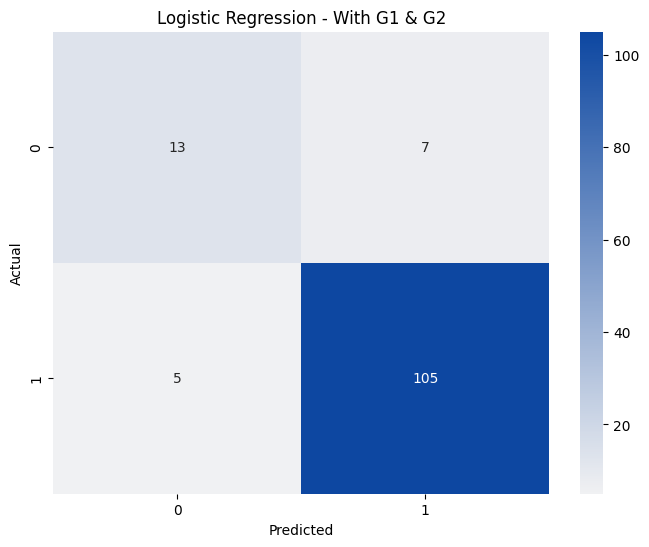

__________________________________________________
HYPERPARAMETER TUNED LOGISTIC REGRESSION MODEL WITH G1 & G2
Best Hyperparameters for Logistic Regression:
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report for Improved Logistic Regression:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        20
           1       0.95      0.95      0.95       110

    accuracy                           0.91       130
   macro avg       0.82      0.82      0.82       130
weighted avg       0.91      0.91      0.91       130


Confusion Matrix for Improved Model:


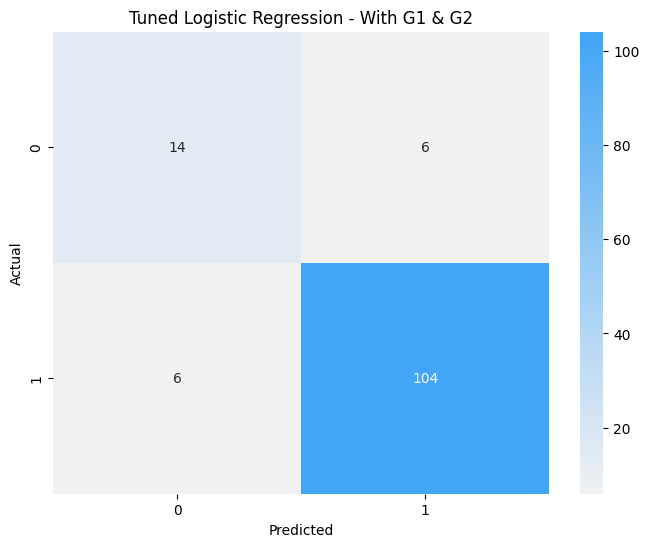

__________________________________________________
RANDOM FOREST MODEL WITH G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        20
           1       0.94      0.95      0.95       110

    accuracy                           0.91       130
   macro avg       0.83      0.80      0.82       130
weighted avg       0.90      0.91      0.91       130

Confusion Matrix:


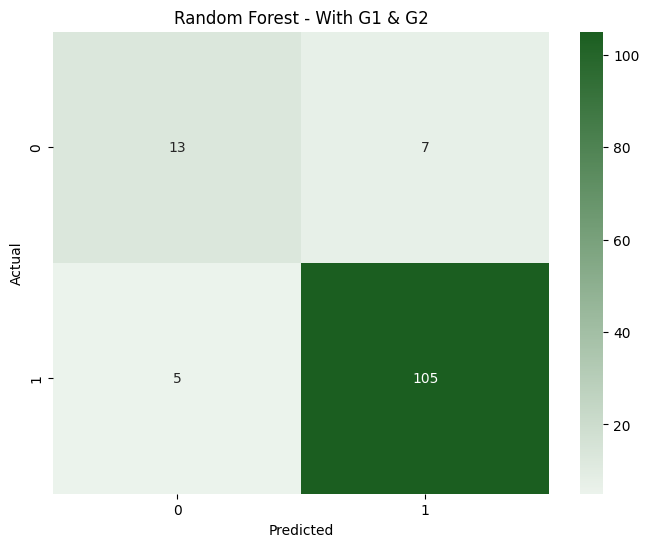

__________________________________________________
HYPERPARAMETER TUNED RANDOM FOREST MODEL WITH G1 & G2
Best Hyperparameters for Random Forest:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}

Classification Report for Tuned Random Forest:
              precision    recall  f1-score   support

           0       0.69      0.55      0.61        20
           1       0.92      0.95      0.94       110

    accuracy                           0.89       130
   macro avg       0.80      0.75      0.77       130
weighted avg       0.89      0.89      0.89       130


Confusion Matrix for Tuned Model:


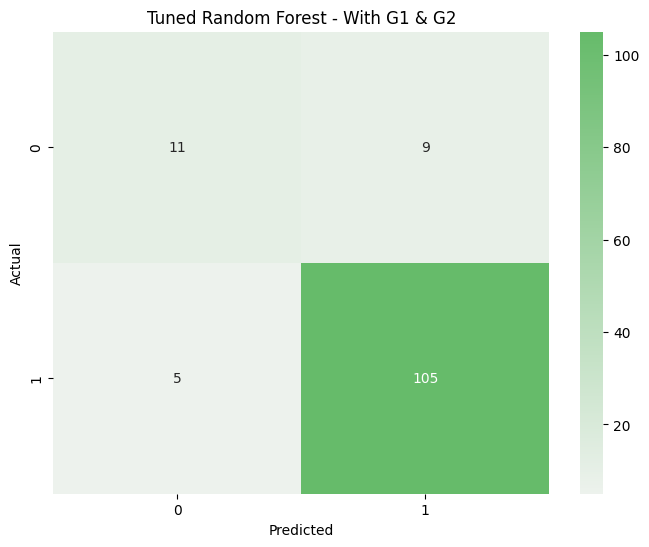

__________________________________________________
GRADIENT BOOSTING MODEL WITH G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.95      0.97      0.96       110

    accuracy                           0.93       130
   macro avg       0.89      0.84      0.86       130
weighted avg       0.93      0.93      0.93       130

Confusion Matrix:


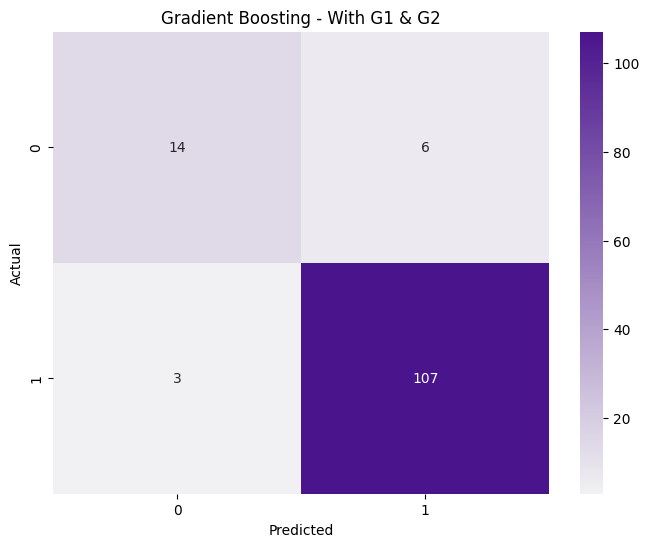

__________________________________________________
TUNED GRADIENT BOOSTING MODEL WITH G1 & G2
Best Hyperparameters for Gradient Boosting:
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 7, 'learning_rate': 0.1}

Classification Report for Tuned Gradient Boosting:
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        20
           1       0.95      0.95      0.95       110

    accuracy                           0.92       130
   macro avg       0.84      0.83      0.83       130
weighted avg       0.91      0.92      0.91       130


Confusion Matrix for Tuned GBM:


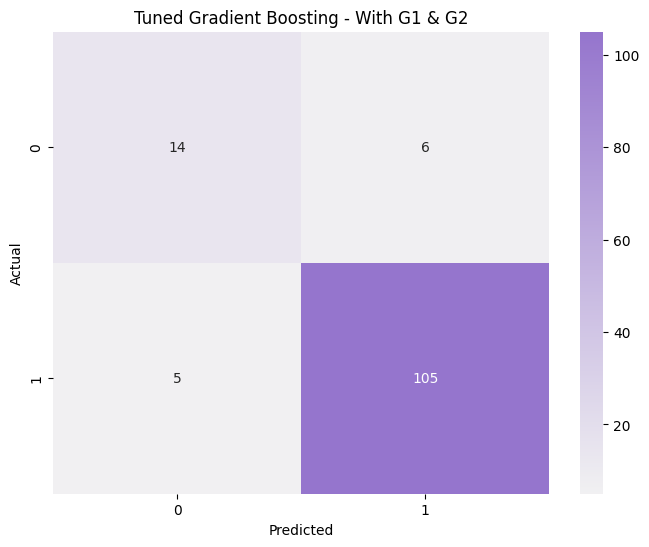

__________________________________________________
XGBOOST MODEL WITH G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        20
           1       0.94      0.93      0.94       110

    accuracy                           0.89       130
   macro avg       0.79      0.81      0.80       130
weighted avg       0.90      0.89      0.89       130

Confusion Matrix:


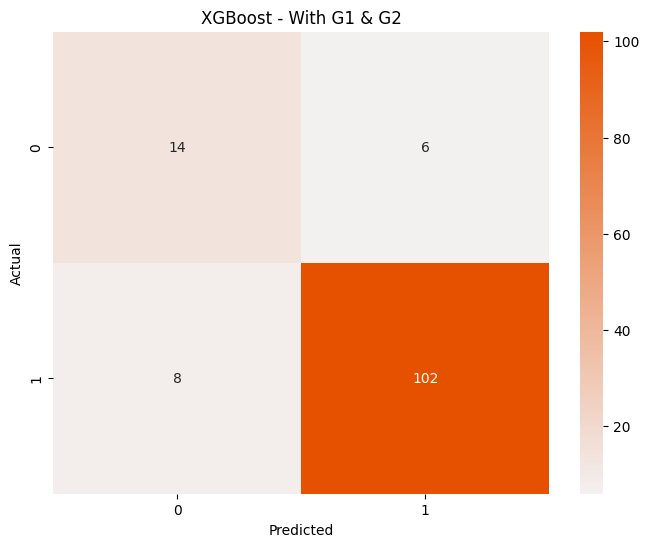

__________________________________________________
TUNED XGBOOST MODEL WITH G1 & G2
Best Hyperparameters for XGBoost:
{'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}

Classification Report for Tuned XGBoost:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        20
           1       0.93      0.95      0.94       110

    accuracy                           0.89       130
   macro avg       0.80      0.77      0.78       130
weighted avg       0.89      0.89      0.89       130


Confusion Matrix for Tuned XGBoost:


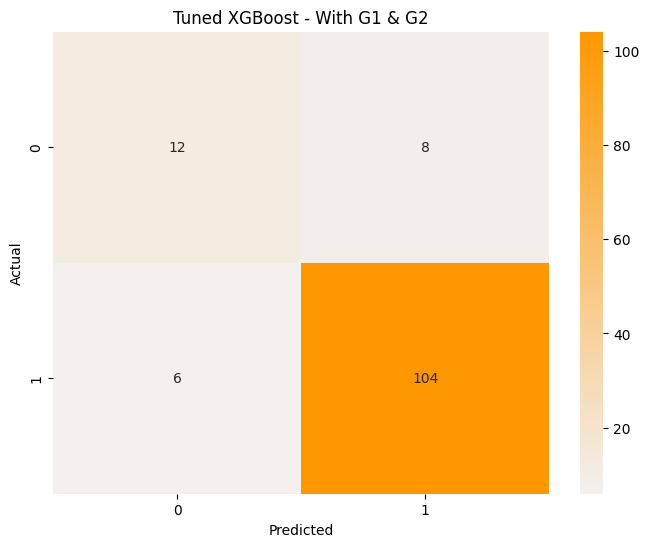

__________________________________________________
SVM MODEL WITH G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.35      0.45        20
           1       0.89      0.96      0.93       110

    accuracy                           0.87       130
   macro avg       0.76      0.66      0.69       130
weighted avg       0.85      0.87      0.85       130

Confusion Matrix:


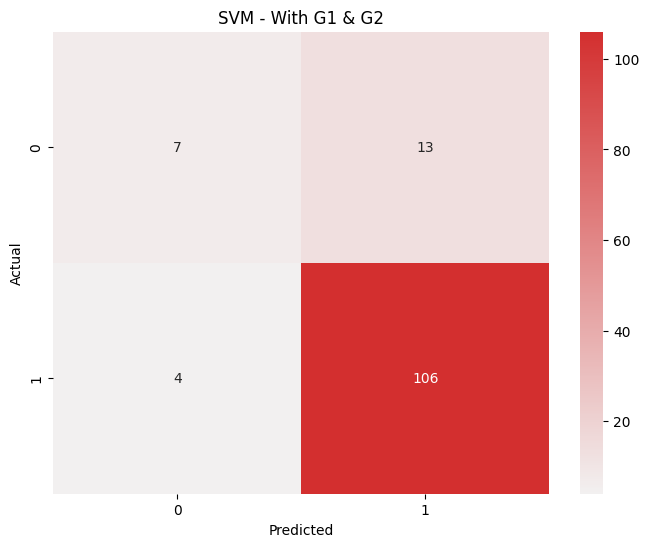

__________________________________________________
TUNED SVM MODEL WITH G1 & G2
Best Hyperparameters for SVM:
{'kernel': 'sigmoid', 'gamma': 0.01, 'degree': 3, 'C': 10}

Classification Report for Tuned SVM:
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        20
           1       0.94      0.94      0.94       110

    accuracy                           0.90       130
   macro avg       0.81      0.82      0.81       130
weighted avg       0.90      0.90      0.90       130


Confusion Matrix for Tuned SVM:


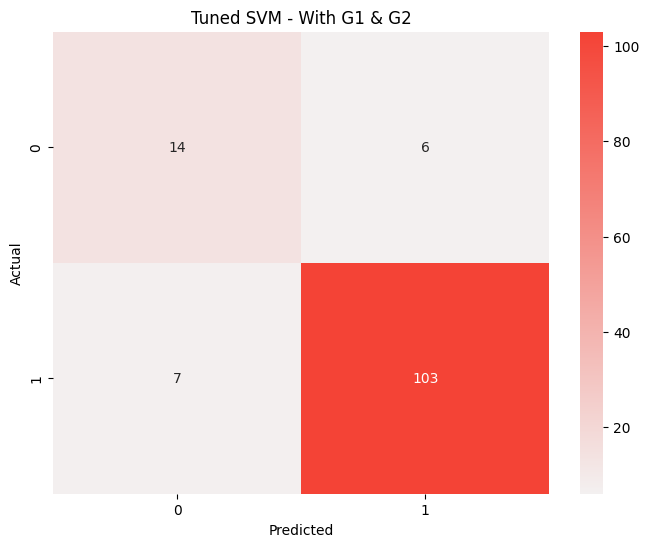

In [24]:
# Initialize results dictionary for comparison
results = {}

# Run all models WITH G1 & G2
print("=" * 60)
print("MODELS WITH G1 & G2 FEATURES")
print("=" * 60)

# Logistic Regression - Base & Tuned
lr_base_acc, lr_base_prec, lr_base_rec, lr_base_f1 = logistic_regression_base(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

lr_tuned_acc, lr_tuned_prec, lr_tuned_rec, lr_tuned_f1 = logistic_regression_tuned(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

# Random Forest - Base & Tuned
rf_base_acc, rf_base_prec, rf_base_rec, rf_base_f1 = random_forest_base(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

rf_tuned_acc, rf_tuned_prec, rf_tuned_rec, rf_tuned_f1 = random_forest_tuned(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

# Gradient Boosting - Base & Tuned
gbm_base_acc, gbm_base_prec, gbm_base_rec, gbm_base_f1 = gradient_boosting_base(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

gbm_tuned_acc, gbm_tuned_prec, gbm_tuned_rec, gbm_tuned_f1 = gradient_boosting_tuned(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

# XGBoost - Base & Tuned
xgb_base_acc, xgb_base_prec, xgb_base_rec, xgb_base_f1 = xgboost_base(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

xgb_tuned_acc, xgb_tuned_prec, xgb_tuned_rec, xgb_tuned_f1 = xgboost_tuned(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

# SVM - Base & Tuned
svm_base_acc, svm_base_prec, svm_base_rec, svm_base_f1 = svm_base(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)
print("_" * 50)

svm_tuned_acc, svm_tuned_prec, svm_tuned_rec, svm_tuned_f1 = svm_tuned(
    X_train_with_grades, X_test_with_grades, "With G1 & G2"
)

# Store results WITH grades
results["with_grades"] = {
    "LR_Base": [lr_base_acc, lr_base_prec, lr_base_rec, lr_base_f1],
    "LR_Tuned": [lr_tuned_acc, lr_tuned_prec, lr_tuned_rec, lr_tuned_f1],
    "RF_Base": [rf_base_acc, rf_base_prec, rf_base_rec, rf_base_f1],
    "RF_Tuned": [rf_tuned_acc, rf_tuned_prec, rf_tuned_rec, rf_tuned_f1],
    "GBM_Base": [gbm_base_acc, gbm_base_prec, gbm_base_rec, gbm_base_f1],
    "GBM_Tuned": [gbm_tuned_acc, gbm_tuned_prec, gbm_tuned_rec, gbm_tuned_f1],
    "XGB_Base": [xgb_base_acc, xgb_base_prec, xgb_base_rec, xgb_base_f1],
    "XGB_Tuned": [xgb_tuned_acc, xgb_tuned_prec, xgb_tuned_rec, xgb_tuned_f1],
    "SVM_Base": [svm_base_acc, svm_base_prec, svm_base_rec, svm_base_f1],
    "SVM_Tuned": [svm_tuned_acc, svm_tuned_prec, svm_tuned_rec, svm_tuned_f1],
}


MODELS WITHOUT G1 & G2 FEATURES
LOGISTIC REGRESSION MODEL WITHOUT G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.25      0.27        20
           1       0.87      0.89      0.88       110

    accuracy                           0.79       130
   macro avg       0.58      0.57      0.57       130
weighted avg       0.78      0.79      0.79       130

Confusion Matrix:


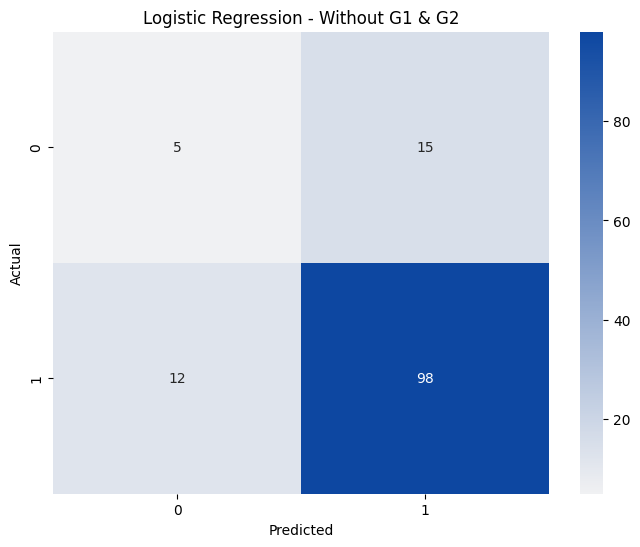

__________________________________________________
HYPERPARAMETER TUNED LOGISTIC REGRESSION MODEL WITHOUT G1 & G2
Best Hyperparameters for Logistic Regression:
{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

Classification Report for Improved Logistic Regression:
              precision    recall  f1-score   support

           0       0.22      0.10      0.14        20
           1       0.85      0.94      0.89       110

    accuracy                           0.81       130
   macro avg       0.54      0.52      0.51       130
weighted avg       0.75      0.81      0.78       130


Confusion Matrix for Improved Model:


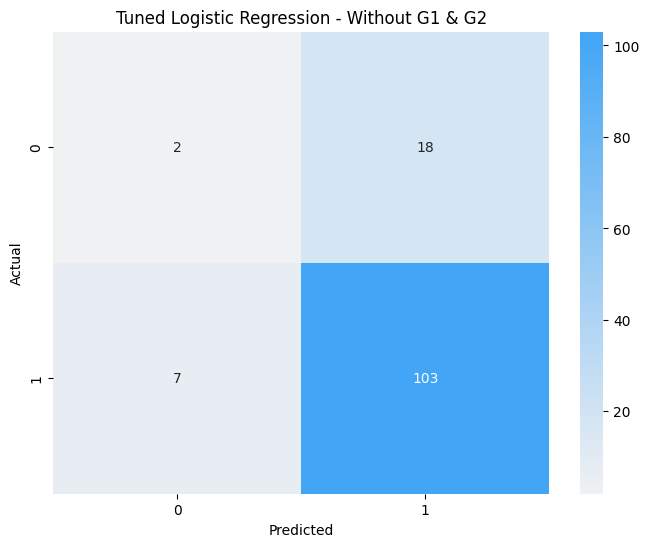

__________________________________________________
RANDOM FOREST MODEL WITHOUT G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        20
           1       0.85      0.95      0.90       110

    accuracy                           0.82       130
   macro avg       0.55      0.52      0.52       130
weighted avg       0.76      0.82      0.78       130

Confusion Matrix:


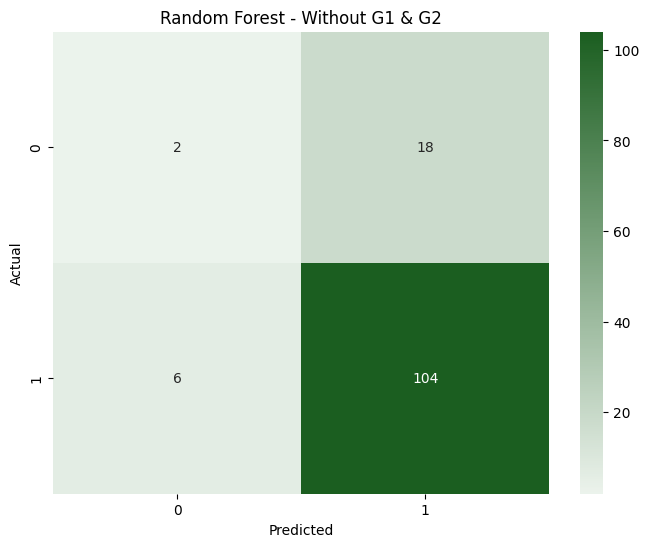

__________________________________________________
HYPERPARAMETER TUNED RANDOM FOREST MODEL WITHOUT G1 & G2
Best Hyperparameters for Random Forest:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': True}

Classification Report for Tuned Random Forest:
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        20
           1       0.85      0.95      0.90       110

    accuracy                           0.82       130
   macro avg       0.55      0.52      0.52       130
weighted avg       0.76      0.82      0.78       130


Confusion Matrix for Tuned Model:


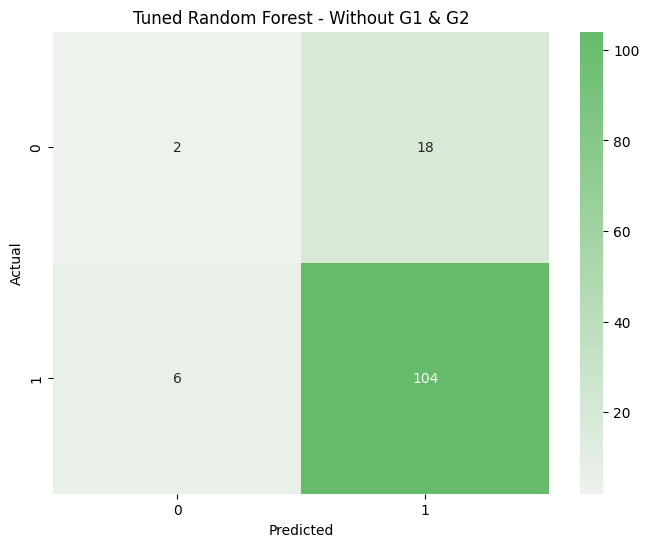

__________________________________________________
GRADIENT BOOSTING MODEL WITHOUT G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.30      0.30        20
           1       0.87      0.87      0.87       110

    accuracy                           0.78       130
   macro avg       0.59      0.59      0.59       130
weighted avg       0.78      0.78      0.78       130

Confusion Matrix:


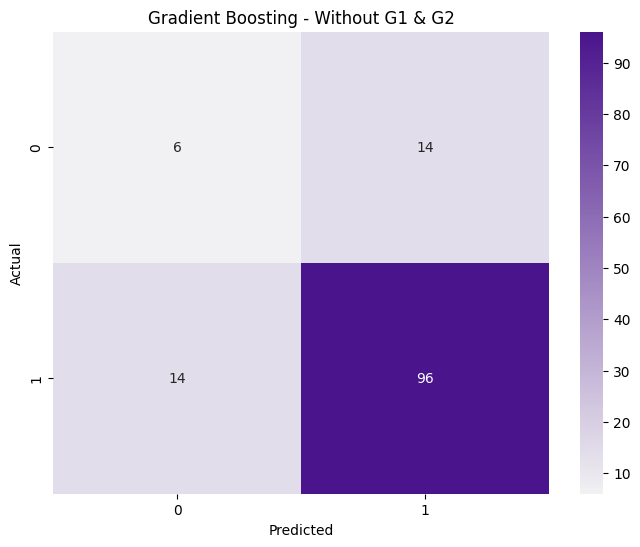

__________________________________________________
TUNED GRADIENT BOOSTING MODEL WITHOUT G1 & G2
Best Hyperparameters for Gradient Boosting:
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 7, 'learning_rate': 0.1}

Classification Report for Tuned Gradient Boosting:
              precision    recall  f1-score   support

           0       0.21      0.20      0.21        20
           1       0.86      0.86      0.86       110

    accuracy                           0.76       130
   macro avg       0.53      0.53      0.53       130
weighted avg       0.76      0.76      0.76       130


Confusion Matrix for Tuned GBM:


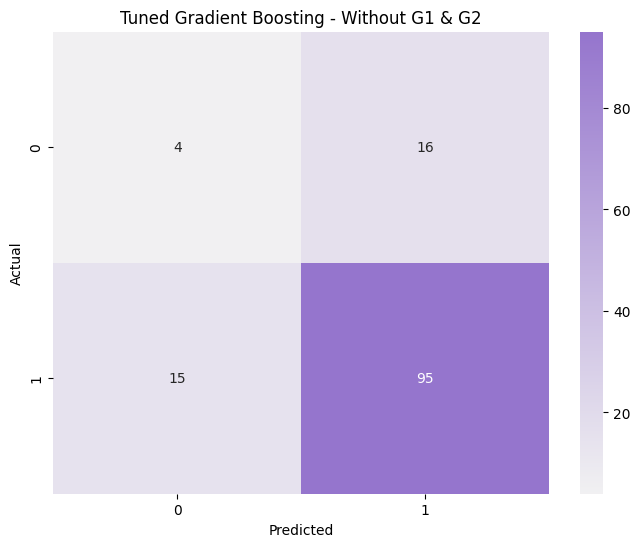

__________________________________________________
XGBOOST MODEL WITHOUT G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.20      0.22        20
           1       0.86      0.89      0.88       110

    accuracy                           0.78       130
   macro avg       0.55      0.55      0.55       130
weighted avg       0.77      0.78      0.77       130

Confusion Matrix:


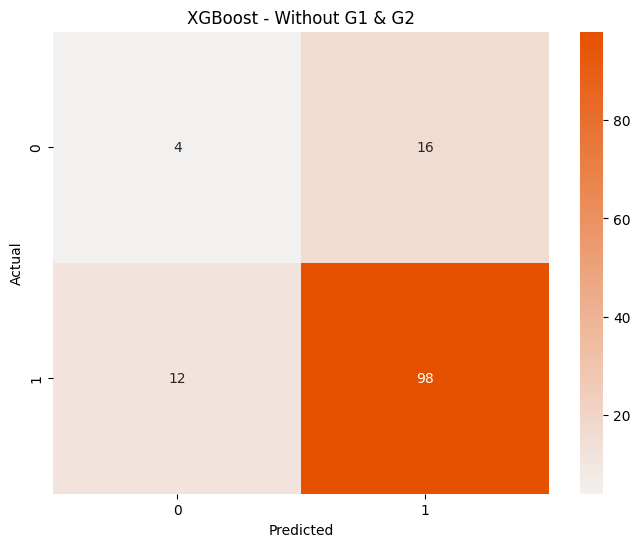

__________________________________________________
TUNED XGBOOST MODEL WITHOUT G1 & G2
Best Hyperparameters for XGBoost:
{'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Classification Report for Tuned XGBoost:
              precision    recall  f1-score   support

           0       0.25      0.20      0.22        20
           1       0.86      0.89      0.88       110

    accuracy                           0.78       130
   macro avg       0.55      0.55      0.55       130
weighted avg       0.77      0.78      0.77       130


Confusion Matrix for Tuned XGBoost:


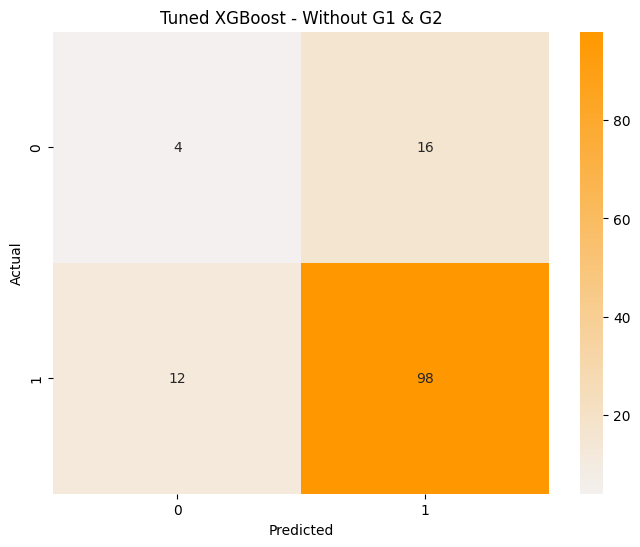

__________________________________________________
SVM MODEL WITHOUT G1 & G2

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        20
           1       0.85      0.95      0.90       110

    accuracy                           0.82       130
   macro avg       0.55      0.52      0.52       130
weighted avg       0.76      0.82      0.78       130

Confusion Matrix:


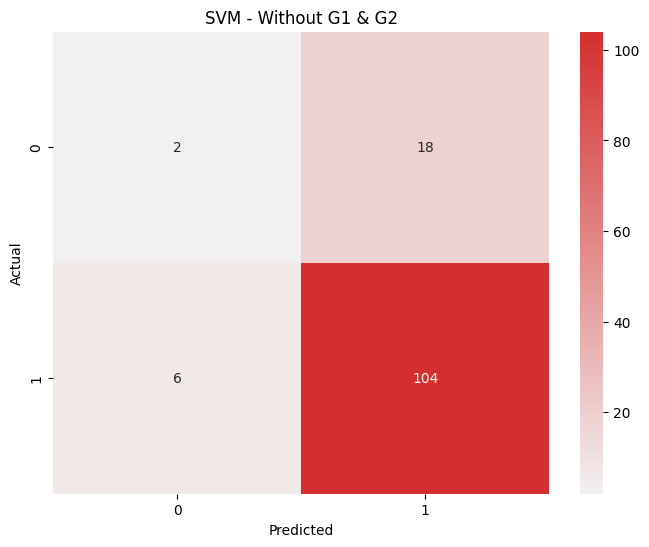

__________________________________________________
TUNED SVM MODEL WITHOUT G1 & G2
Best Hyperparameters for SVM:
{'kernel': 'sigmoid', 'gamma': 0.01, 'degree': 3, 'C': 10}

Classification Report for Tuned SVM:
              precision    recall  f1-score   support

           0       0.25      0.20      0.22        20
           1       0.86      0.89      0.88       110

    accuracy                           0.78       130
   macro avg       0.55      0.55      0.55       130
weighted avg       0.77      0.78      0.77       130


Confusion Matrix for Tuned SVM:


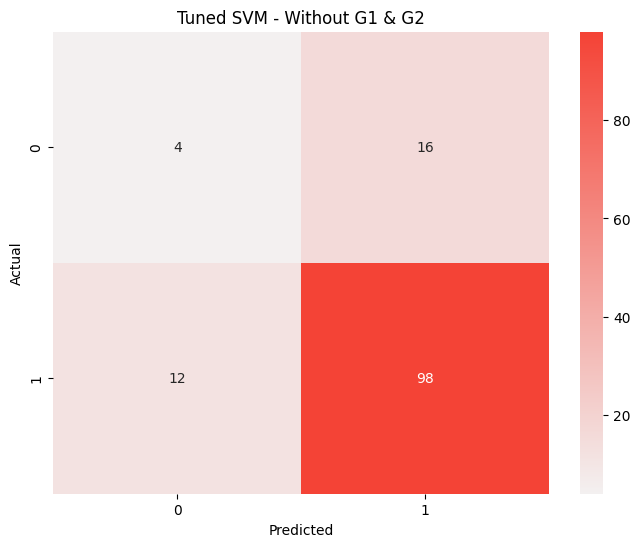

In [25]:
# Run all models WITHOUT G1 & G2
print("\n" + "=" * 60)
print("MODELS WITHOUT G1 & G2 FEATURES")
print("=" * 60)

# Logistic Regression - Base & Tuned
lr_base_acc_no, lr_base_prec_no, lr_base_rec_no, lr_base_f1_no = (
    logistic_regression_base(
        X_train_without_grades, X_test_without_grades, "Without G1 & G2"
    )
)
print("_" * 50)

lr_tuned_acc_no, lr_tuned_prec_no, lr_tuned_rec_no, lr_tuned_f1_no = (
    logistic_regression_tuned(
        X_train_without_grades, X_test_without_grades, "Without G1 & G2"
    )
)
print("_" * 50)

# Random Forest - Base & Tuned
rf_base_acc_no, rf_base_prec_no, rf_base_rec_no, rf_base_f1_no = random_forest_base(
    X_train_without_grades, X_test_without_grades, "Without G1 & G2"
)
print("_" * 50)

rf_tuned_acc_no, rf_tuned_prec_no, rf_tuned_rec_no, rf_tuned_f1_no = (
    random_forest_tuned(
        X_train_without_grades, X_test_without_grades, "Without G1 & G2"
    )
)
print("_" * 50)

# Gradient Boosting - Base & Tuned
gbm_base_acc_no, gbm_base_prec_no, gbm_base_rec_no, gbm_base_f1_no = (
    gradient_boosting_base(
        X_train_without_grades, X_test_without_grades, "Without G1 & G2"
    )
)
print("_" * 50)

gbm_tuned_acc_no, gbm_tuned_prec_no, gbm_tuned_rec_no, gbm_tuned_f1_no = (
    gradient_boosting_tuned(
        X_train_without_grades, X_test_without_grades, "Without G1 & G2"
    )
)
print("_" * 50)

# XGBoost - Base & Tuned
xgb_base_acc_no, xgb_base_prec_no, xgb_base_rec_no, xgb_base_f1_no = xgboost_base(
    X_train_without_grades, X_test_without_grades, "Without G1 & G2"
)
print("_" * 50)

xgb_tuned_acc_no, xgb_tuned_prec_no, xgb_tuned_rec_no, xgb_tuned_f1_no = xgboost_tuned(
    X_train_without_grades, X_test_without_grades, "Without G1 & G2"
)
print("_" * 50)

# SVM - Base & Tuned
svm_base_acc_no, svm_base_prec_no, svm_base_rec_no, svm_base_f1_no = svm_base(
    X_train_without_grades, X_test_without_grades, "Without G1 & G2"
)
print("_" * 50)

svm_tuned_acc_no, svm_tuned_prec_no, svm_tuned_rec_no, svm_tuned_f1_no = svm_tuned(
    X_train_without_grades, X_test_without_grades, "Without G1 & G2"
)

# Store results WITHOUT grades
results["without_grades"] = {
    "LR_Base": [lr_base_acc_no, lr_base_prec_no, lr_base_rec_no, lr_base_f1_no],
    "LR_Tuned": [lr_tuned_acc_no, lr_tuned_prec_no, lr_tuned_rec_no, lr_tuned_f1_no],
    "RF_Base": [rf_base_acc_no, rf_base_prec_no, rf_base_rec_no, rf_base_f1_no],
    "RF_Tuned": [rf_tuned_acc_no, rf_tuned_prec_no, rf_tuned_rec_no, rf_tuned_f1_no],
    "GBM_Base": [gbm_base_acc_no, gbm_base_prec_no, gbm_base_rec_no, gbm_base_f1_no],
    "GBM_Tuned": [
        gbm_tuned_acc_no,
        gbm_tuned_prec_no,
        gbm_tuned_rec_no,
        gbm_tuned_f1_no,
    ],
    "XGB_Base": [xgb_base_acc_no, xgb_base_prec_no, xgb_base_rec_no, xgb_base_f1_no],
    "XGB_Tuned": [
        xgb_tuned_acc_no,
        xgb_tuned_prec_no,
        xgb_tuned_rec_no,
        xgb_tuned_f1_no,
    ],
    "SVM_Base": [svm_base_acc_no, svm_base_prec_no, svm_base_rec_no, svm_base_f1_no],
    "SVM_Tuned": [
        svm_tuned_acc_no,
        svm_tuned_prec_no,
        svm_tuned_rec_no,
        svm_tuned_f1_no,
    ],
}


COMPREHENSIVE MODEL COMPARISON
Full Model Comparison Table:
           Accuracy_WITH_GRADES  Precision_WITH_GRADES  Recall_WITH_GRADES  \
LR_Base                  0.9077                 0.9375              0.9545   
LR_Tuned                 0.9077                 0.9455              0.9455   
RF_Base                  0.9077                 0.9375              0.9545   
RF_Tuned                 0.8923                 0.9211              0.9545   
GBM_Base                 0.9308                 0.9469              0.9727   
GBM_Tuned                0.9154                 0.9459              0.9545   
XGB_Base                 0.8923                 0.9444              0.9273   
XGB_Tuned                0.8923                 0.9286              0.9455   
SVM_Base                 0.8692                 0.8908              0.9636   
SVM_Tuned                0.9000                 0.9450              0.9364   

           F1-Score_WITH_GRADES  Accuracy_WITHOUT_GRADES  \
LR_Base             

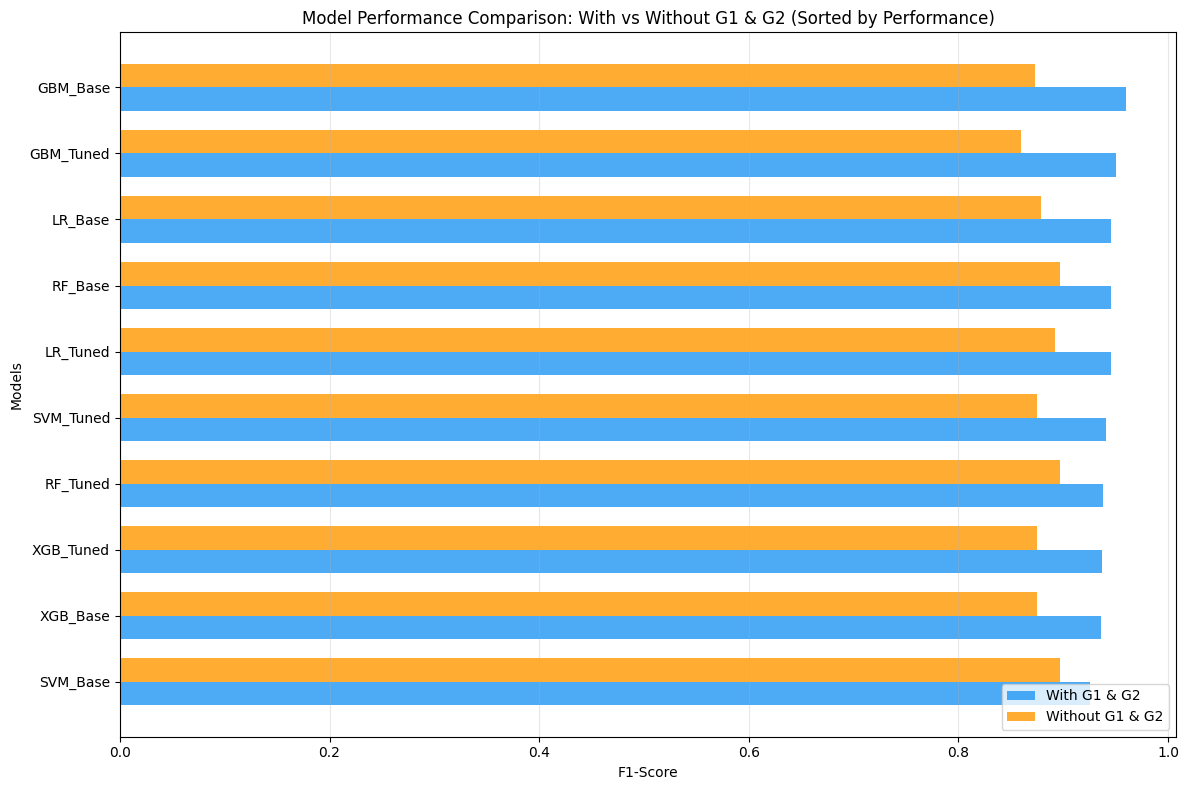


Best Performing Models:
WITH G1 & G2: GBM_Base (F1: 0.9596)
WITHOUT G1 & G2: RF_Base (F1: 0.8966)

Improvement from including G1 & G2:
LR_Base: +0.0670 (7.6% improvement)
LR_Tuned: +0.0537 (6.0% improvement)
RF_Base: +0.0494 (5.5% improvement)
RF_Tuned: +0.0409 (4.6% improvement)
GBM_Base: +0.0869 (10.0% improvement)
GBM_Tuned: +0.0905 (10.5% improvement)
XGB_Base: +0.0608 (6.9% improvement)
XGB_Tuned: +0.0619 (7.1% improvement)
SVM_Base: +0.0292 (3.3% improvement)
SVM_Tuned: +0.0656 (7.5% improvement)


In [26]:
# Create comprehensive comparison DataFrame
print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

# Create comparison dataframes
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# WITH G1 & G2 DataFrame
df_with_grades = pd.DataFrame(results["with_grades"], index=metrics).T
df_with_grades.columns = [f"{col}_WITH_GRADES" for col in df_with_grades.columns]

# WITHOUT G1 & G2 DataFrame
df_without_grades = pd.DataFrame(results["without_grades"], index=metrics).T
df_without_grades.columns = [
    f"{col}_WITHOUT_GRADES" for col in df_without_grades.columns
]

# Combine both dataframes
comparison_df = pd.concat([df_with_grades, df_without_grades], axis=1)

# Round to 4 decimal places for better readability
comparison_df = comparison_df.round(4)

print("Full Model Comparison Table:")
print(comparison_df)

# Create a focused comparison (F1-Score only)
f1_comparison = pd.DataFrame(
    {
        "With G1 & G2": [
            results["with_grades"][model][3] for model in results["with_grades"].keys()
        ],
        "Without G1 & G2": [
            results["without_grades"][model][3]
            for model in results["without_grades"].keys()
        ],
    },
    index=list(results["with_grades"].keys()),
)

print("\nF1-Score Comparison:")
print(f1_comparison.round(4))

# Visualize F1-Score comparison with horizontal bars (sorted)
# Sort by "With G1 & G2" performance (descending)
f1_comparison_sorted = f1_comparison.sort_values(
    "With G1 & G2", ascending=True
)  # ascending=True for horizontal bars

plt.figure(figsize=(12, 8))
y_pos = np.arange(len(f1_comparison_sorted.index))
bar_height = 0.35

plt.barh(
    y_pos - bar_height / 2,
    f1_comparison_sorted["With G1 & G2"],
    bar_height,
    label="With G1 & G2",
    alpha=0.8,
    color="#2196f3",
)
plt.barh(
    y_pos + bar_height / 2,
    f1_comparison_sorted["Without G1 & G2"],
    bar_height,
    label="Without G1 & G2",
    alpha=0.8,
    color="#ff9800",
)

plt.ylabel("Models")
plt.xlabel("F1-Score")
plt.title(
    "Model Performance Comparison: With vs Without G1 & G2 (Sorted by Performance)"
)
plt.yticks(y_pos, f1_comparison_sorted.index)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

# Find best performing models
print("\nBest Performing Models:")
print(
    f"WITH G1 & G2: {f1_comparison['With G1 & G2'].idxmax()} "
    f"(F1: {f1_comparison['With G1 & G2'].max():.4f})"
)
print(
    f"WITHOUT G1 & G2: {f1_comparison['Without G1 & G2'].idxmax()} "
    f"(F1: {f1_comparison['Without G1 & G2'].max():.4f})"
)

# Calculate improvement from G1 & G2
print("\nImprovement from including G1 & G2:")
improvements = f1_comparison["With G1 & G2"] - f1_comparison["Without G1 & G2"]
for model in improvements.index:
    improvement = improvements[model]
    pct_improvement = (improvement / f1_comparison.loc[model, "Without G1 & G2"]) * 100
    print(f"{model}: +{improvement:.4f} ({pct_improvement:.1f}% improvement)")

# Feature Importance Analysis

Now let's analyze which features are most important for predicting student performance in both scenarios.

In [ ]:
# Feature Importance Analysis - Random Forest Models
print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Train Random Forest models to extract feature importance
rf_with_grades = RandomForestClassifier(n_estimators=100, random_state=42)
rf_without_grades = RandomForestClassifier(n_estimators=100, random_state=42)

# Train models
rf_with_grades.fit(X_train_with_grades, y_train)
rf_without_grades.fit(X_train_without_grades, y_train)

# Get feature importance for WITH G1 & G2 scenario
feature_names_with = X_with_grades.columns
feature_importance_with = pd.DataFrame(
    {"feature": feature_names_with, "importance": rf_with_grades.feature_importances_}
).sort_values("importance", ascending=False)

print("\nTop 10 Features - WITH G1 & G2 (Mid-term Prediction):")
print("Feature\t\t\tImportance")
print("-" * 40)
for i, (_, row) in enumerate(feature_importance_with.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:15s}\t{row['importance']:.4f}")

# Get feature importance for WITHOUT G1 & G2 scenario
feature_names_without = X_without_grades.columns
feature_importance_without = pd.DataFrame(
    {
        "feature": feature_names_without,
        "importance": rf_without_grades.feature_importances_,
    }
).sort_values("importance", ascending=False)

print("\nTop 10 Features - WITHOUT G1 & G2 (Early Intervention):")
print("Feature\t\t\tImportance")
print("-" * 40)
for i, (_, row) in enumerate(feature_importance_without.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:15s}\t{row['importance']:.4f}")

# Model performance validation
y_pred_with_fi = rf_with_grades.predict(X_test_with_grades)
y_pred_without_fi = rf_without_grades.predict(X_test_without_grades)

f1_with_fi = f1_score(y_test, y_pred_with_fi)
f1_without_fi = f1_score(y_test, y_pred_without_fi)

print(f"\nModel Performance Validation:")
print(f"WITH G1 & G2 - F1 Score: {f1_with_fi:.4f}")
print(f"WITHOUT G1 & G2 - F1 Score: {f1_without_fi:.4f}")
print(
    f"Performance Drop: {f1_with_fi - f1_without_fi:.4f} ({((f1_with_fi - f1_without_fi)/f1_with_fi)*100:.1f}%)"
)

FEATURE IMPORTANCE ANALYSIS

Top 10 Features - WITH G1 & G2 (Mid-term Prediction):
Feature			Importance
----------------------------------------
 1. G2             	0.2718
 2. G1             	0.2192
 3. failures       	0.0538
 4. higher         	0.0400
 5. attendance_proxy	0.0290
 6. famrel         	0.0250
 7. Walc           	0.0238
 8. school         	0.0229
 9. absences       	0.0216
10. goout          	0.0212

Top 10 Features - WITHOUT G1 & G2 (Early Intervention):
Feature			Importance
----------------------------------------
 1. failures       	0.1120
 2. higher         	0.0650
 3. school         	0.0539
 4. attendance_proxy	0.0477
 5. Walc           	0.0462
 6. absences       	0.0458
 7. freetime       	0.0437
 8. famrel         	0.0425
 9. goout          	0.0384
10. Fedu           	0.0379

Model Performance Validation:
WITH G1 & G2 - F1 Score: 0.9459
WITHOUT G1 & G2 - F1 Score: 0.8966
Performance Drop: 0.0494 (5.2%)


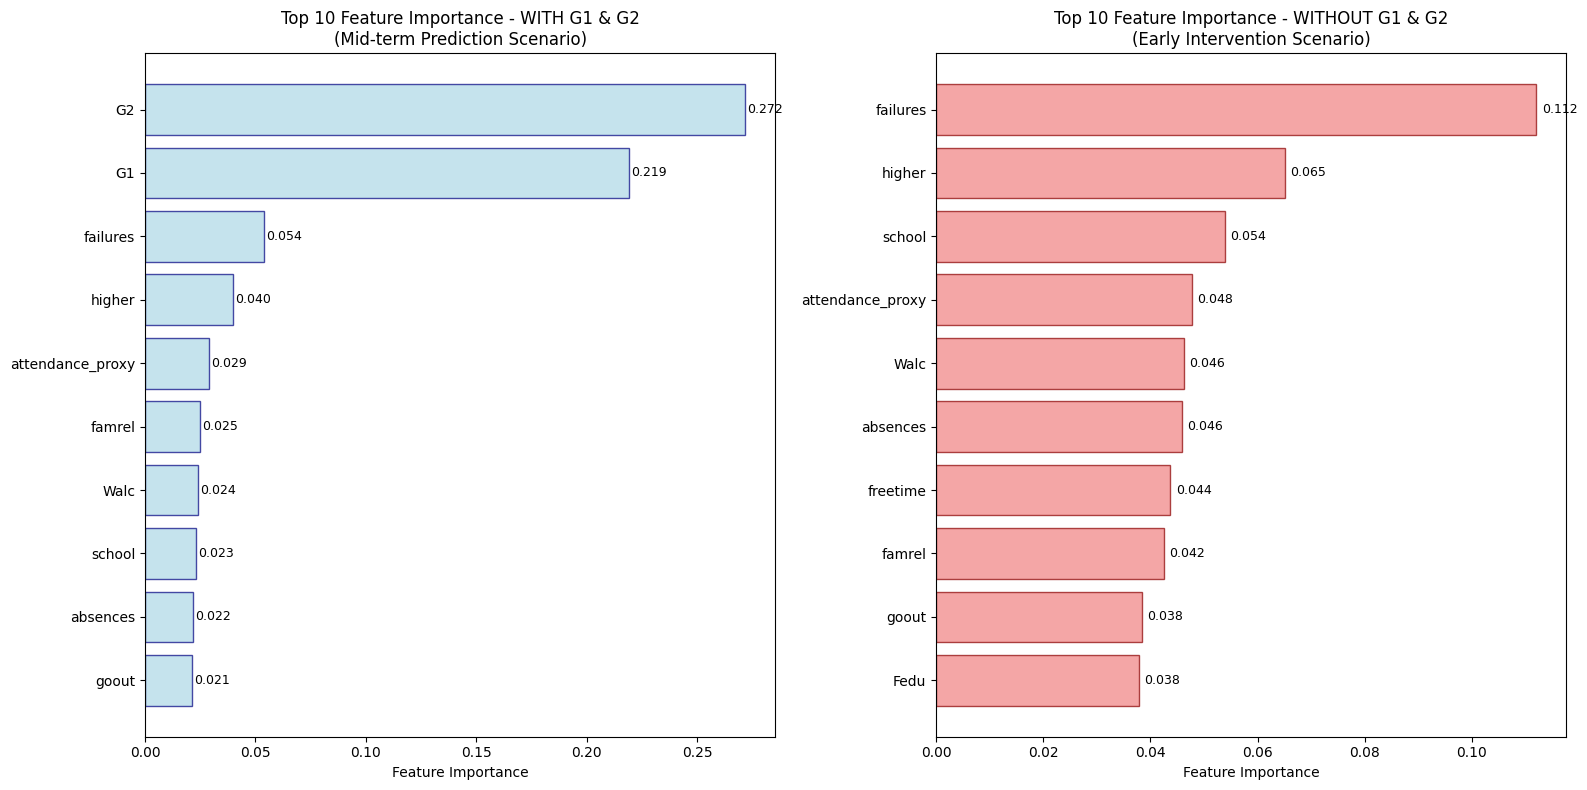


FEATURE IMPORTANCE COMPARISON (COMMON FEATURES)
Features ranked by importance in Early Intervention scenario:
Feature			With G1&G2	Without G1&G2	Difference	Ratio
---------------------------------------------------------------------------
failures       	0.0538		0.1120		+0.0582		2.08
higher         	0.0400		0.0650		+0.0250		1.62
school         	0.0229		0.0539		+0.0311		2.36
attendance_proxy	0.0290		0.0477		+0.0187		1.65
Walc           	0.0238		0.0462		+0.0224		1.94
absences       	0.0216		0.0458		+0.0242		2.12
freetime       	0.0203		0.0437		+0.0234		2.16
famrel         	0.0250		0.0425		+0.0174		1.70
goout          	0.0212		0.0384		+0.0172		1.81
Fedu           	0.0181		0.0379		+0.0198		2.09


In [ ]:
# Visualize Feature Importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# WITH G1 & G2
top_features_with = feature_importance_with.head(10)
bars1 = ax1.barh(
    range(len(top_features_with)),
    top_features_with["importance"],
    color="lightblue",
    edgecolor="navy",
    alpha=0.7,
)
ax1.set_yticks(range(len(top_features_with)))
ax1.set_yticklabels(top_features_with["feature"])
ax1.set_xlabel("Feature Importance")
ax1.set_title(
    "Top 10 Feature Importance - WITH G1 & G2\n(Mid-term Prediction Scenario)"
)
ax1.invert_yaxis()

# Add importance values on bars
for i, (bar, importance) in enumerate(zip(bars1, top_features_with["importance"])):
    ax1.text(
        bar.get_width() + 0.001,
        bar.get_y() + bar.get_height() / 2,
        f"{importance:.3f}",
        va="center",
        ha="left",
        fontsize=9,
    )

# WITHOUT G1 & G2
top_features_without = feature_importance_without.head(10)
bars2 = ax2.barh(
    range(len(top_features_without)),
    top_features_without["importance"],
    color="lightcoral",
    edgecolor="darkred",
    alpha=0.7,
)
ax2.set_yticks(range(len(top_features_without)))
ax2.set_yticklabels(top_features_without["feature"])
ax2.set_xlabel("Feature Importance")
ax2.set_title(
    "Top 10 Feature Importance - WITHOUT G1 & G2\n(Early Intervention Scenario)"
)
ax2.invert_yaxis()

# Add importance values on bars
for i, (bar, importance) in enumerate(zip(bars2, top_features_without["importance"])):
    ax2.text(
        bar.get_width() + 0.001,
        bar.get_y() + bar.get_height() / 2,
        f"{importance:.3f}",
        va="center",
        ha="left",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

# Feature importance comparison for common features
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE COMPARISON (COMMON FEATURES)")
print("=" * 60)

# Get common features between both scenarios
common_features = set(feature_names_with) & set(feature_names_without)
comparison_data = []

for feature in common_features:
    importance_with = feature_importance_with[
        feature_importance_with["feature"] == feature
    ]["importance"].iloc[0]
    importance_without = feature_importance_without[
        feature_importance_without["feature"] == feature
    ]["importance"].iloc[0]

    comparison_data.append(
        {
            "feature": feature,
            "with_grades": importance_with,
            "without_grades": importance_without,
            "difference": importance_without - importance_with,
            "ratio": (
                importance_without / importance_with
                if importance_with > 0
                else float("inf")
            ),
        }
    )

comparison_df_fi = pd.DataFrame(comparison_data).sort_values(
    "without_grades", ascending=False
)

print("Features ranked by importance in Early Intervention scenario:")
print("Feature\t\t\tWith G1&G2\tWithout G1&G2\tDifference\tRatio")
print("-" * 75)
for _, row in comparison_df_fi.head(10).iterrows():
    print(
        f"{row['feature']:15s}\t{row['with_grades']:.4f}\t\t{row['without_grades']:.4f}\t\t{row['difference']:+.4f}\t\t{row['ratio']:.2f}"
    )

In [ ]:
# Feature Importance Summary for Technical Report
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE SUMMARY FOR TECHNICAL REPORT")
print("=" * 60)

# Feature descriptions dictionary
feature_descriptions = {
    "failures": "Previous academic failures",
    "higher": "Higher education aspirations",
    "absences": "School absences",
    "age": "Student age",
    "studytime": "Weekly study time",
    "Medu": "Mother education level",
    "Fedu": "Father education level",
    "freetime": "Free time after school",
    "goout": "Going out with friends",
    "Dalc": "Workday alcohol consumption",
    "Walc": "Weekend alcohol consumption",
    "health": "Current health status",
    "famrel": "Quality of family relationships",
    "school": "School (GP or MS)",
    "sex": "Student gender",
    "traveltime": "Home to school travel time",
    "G1": "First period grade",
    "G2": "Second period grade",
    "attendance_proxy": "Attendance percentage",
    "schoolsup": "Extra educational support",
    "famsup": "Family educational support",
    "paid": "Extra paid classes",
    "activities": "Extra-curricular activities",
    "nursery": "Attended nursery school",
    "internet": "Internet access at home",
    "romantic": "In a romantic relationship",
}

print("\n**Top Features (Random Forest - Early Intervention Scenario):**")
for i, (_, row) in enumerate(feature_importance_without.head(10).iterrows(), 1):
    feature_name = row["feature"]
    importance = row["importance"]
    description = feature_descriptions.get(
        feature_name, feature_name.replace("_", " ").title()
    )
    print(f"{i}. `{feature_name}` ({importance:.3f}): {description}")

print("\n**Key Insights:**")
print(
    "1. **Behavioral Factors Dominate**: Non-academic features show strong predictive power"
)
print("2. **Past Performance Critical**: Previous failures emerge as the top predictor")
print("3. **Motivational Factors**: Higher education aspirations are highly predictive")
print("4. **Attendance Matters**: School absences rank consistently high")
print(
    "5. **Study Habits**: Weekly study time shows moderate but significant importance"
)

# Calculate feature categories
academic_features = [
    "failures",
    "higher",
    "studytime",
    "schoolsup",
    "paid",
    "activities",
]
behavioral_features = ["absences", "goout", "freetime", "Dalc", "Walc", "romantic"]
demographic_features = ["age", "sex", "Medu", "Fedu", "school", "traveltime"]
family_features = ["famrel", "famsup", "health", "internet"]

academic_importance = sum(
    [
        row["importance"]
        for _, row in feature_importance_without.iterrows()
        if row["feature"] in academic_features
    ]
)
behavioral_importance = sum(
    [
        row["importance"]
        for _, row in feature_importance_without.iterrows()
        if row["feature"] in behavioral_features
    ]
)
demographic_importance = sum(
    [
        row["importance"]
        for _, row in feature_importance_without.iterrows()
        if row["feature"] in demographic_features
    ]
)
family_importance = sum(
    [
        row["importance"]
        for _, row in feature_importance_without.iterrows()
        if row["feature"] in family_features
    ]
)

print(f"\n**Feature Category Importance (Early Intervention):**")
print(f"- Academic/Motivational: {academic_importance:.3f}")
print(f"- Behavioral: {behavioral_importance:.3f}")
print(f"- Demographic: {demographic_importance:.3f}")
print(f"- Family/Social: {family_importance:.3f}")

print(f"\n**Model Performance Comparison:**")
print(f"- Random Forest WITH G1&G2: F1 = {f1_with_fi:.4f}")
print(f"- Random Forest WITHOUT G1&G2: F1 = {f1_without_fi:.4f}")
print(
    f"- Performance Gap: {f1_with_fi - f1_without_fi:.4f} ({((f1_with_fi - f1_without_fi)/f1_with_fi)*100:.1f}% decrease)"
)

print("\n**Business Implications:**")
print(
    "1. **Early Warning System**: Focus on students with past failures and low higher education aspirations"
)
print("2. **Behavioral Monitoring**: Track attendance patterns and social behavior")
print(
    "3. **Family Engagement**: Consider parental education levels in intervention strategies"
)
print(
    "4. **Motivational Support**: Address higher education aspirations early in academic year"
)


FEATURE IMPORTANCE SUMMARY FOR TECHNICAL REPORT

**Top Features (Random Forest - Early Intervention Scenario):**
1. `failures` (0.112): Previous academic failures
2. `higher` (0.065): Higher education aspirations
3. `school` (0.054): School (GP or MS)
4. `attendance_proxy` (0.048): Attendance percentage
5. `Walc` (0.046): Weekend alcohol consumption
6. `absences` (0.046): School absences
7. `freetime` (0.044): Free time after school
8. `famrel` (0.042): Quality of family relationships
9. `goout` (0.038): Going out with friends
10. `Fedu` (0.038): Father education level

**Key Insights:**
1. **Behavioral Factors Dominate**: Non-academic features show strong predictive power
2. **Past Performance Critical**: Previous failures emerge as the top predictor
3. **Motivational Factors**: Higher education aspirations are highly predictive
4. **Attendance Matters**: School absences rank consistently high
5. **Study Habits**: Weekly study time shows moderate but significant importance

**Feature